<a href="https://colab.research.google.com/github/BorjaZarco/Smile-Recognition-Model/blob/master/FacialExpression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smile Recognition Model

This is an attempt to build an smile recognition model using a convolutional neural network built with Keras.


## Step 1: Data Preprocessing

First of all, we need to get the data from the uploaded files and apply the correct operations before training the model. At this point all the necessary import will be done. The image dataset was obtained from the [LFW Face Database](http://vis-www.cs.umass.edu/lfw/) and the labels for those images were obtained from [Mendeley Data](https://data.mendeley.com/datasets/yz4v8tb3tp/5).  The LFW Dataset was not originally meant to be used for a smile recognition model, but thanks to the labels given in the Mendeley Data page, this project could be done. Despite of this preprocessing, this dataset was chosen among others because its images included background noise, like other people or objects, different conditions and poses. 

---

The original dataset was split into two folders "smiles" and "no_smiles" using the following simple python script that read the smiles.txt and nonsmiles.txt files that contained which images from the LFW Dataset showed people smiling or not. 

In [0]:
# from shutil import copyfile
# import os

# smiles_dir = "./smiles"
# no_smiles_dir = "./no_smiles"
# smiles = open("SMILE.txt", "r")
# no_smiles = open("NON-SMILE.txt", "r")

# index = 0
# for filename in smiles.read().split("\n"):
#     print("\rCopiando SMILES... [%s/%s]: %s" % (index, 603, filename), end='')
#     if not os.path.exists(smiles_dir):
#         os.makedirs(smiles_dir)
#         print("Created: " + os.path.abspath(smiles_dir))
#     if ".jpg" in filename:
#         copyfile("./dataset/" + filename, os.path.abspath(smiles_dir)+ "\\" + filename)
#     index += 1

# index = 0
# for filename in no_smiles.read().split("\n"):
#     print("\rCopiando NO no_SMILES... [%s/%s]: %s \t" % (index, 603, filename), end='')
#     if not os.path.exists(no_smiles_dir):
#         os.makedirs(no_smiles_dir)
#         print("Created: " + os.path.abspath(no_smiles_dir))
#     if ".jpg" in filename:
#         copyfile("./dataset/" + filename, os.path.abspath(no_smiles_dir)+ "\\" + filename)
#     index += 1

Then, both datasets were uploaded to a private Google Colab Folder. Therefore, the next step is to mount this private drive in order to use that datase. It is also recommendable to check if the drive is correctly mounted and that we have access to those folders. Most necessary imports are also done. 

In [0]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image


from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


no_smiles  smiles


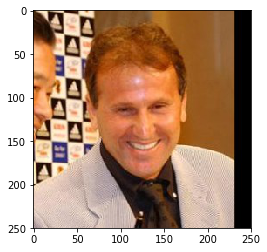

In [0]:
!ls "/content/drive/My Drive/MI_ULPGC/Tercero/S2/FSI/PRACTICA/CNN/DATASET"

pil_im = Image.open('/content/drive/My Drive/MI_ULPGC/Tercero/S2/FSI/PRACTICA/CNN/DATASET/smiles/Zico_0003.jpg', 'r')
imshow(np.asarray(pil_im))

## Step 2: Data augmentation.

During this part we will provide our dataset to ImageDataGenerator for to do some data augmentation of our dataset. This data augmentation will consist just on a horizontal flip, given the fact that zooming or rotating is not natural in this case (zooming mat cause the face to disappear).

We will also split the Dataset into two: training and validation, being the training dataset a 80% of the original one and the validation the remaining 20%. All the keras necessary imports will be done before all the process is started   

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras
from time import time

Using TensorFlow backend.


In [0]:
batch_size = 20

train_data_dir = '/content/drive/My Drive/MI_ULPGC/Tercero/S2/FSI/PRACTICA/CNN/DATASET'
validation_data_dir = '/content/drive/My Drive/MI_ULPGC/Tercero/S2/FSI/PRACTICA/CNN/DATASET'

train_datagen = ImageDataGenerator(
        rescale=1./255,
#         zoom_range=0.2,
#         shear_range=0.3,        
        validation_split=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(250, 250),
        batch_size=10,
        class_mode='binary',
        subset='validation')

Found 963 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


## Step 3: Model Training. 

The structure of the model was decided after reading a [Hanoi University paper](https://www.researchgate.net/publication/321259348_Facial_smile_detection_using_convolutional_neural_networks). This structure was reproduced, but then discarded after realising that the dataset used for this study may me much more complex than the one used in this project, so less layers and neurons per layer were needed. 


In [0]:
# MODEL --------------------------------------------------

# HANOI UNIVERSITY
# model = Sequential()
# model.add(Conv2D(32, 
#                  strides=1,
#                  kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=(250, 250, 3)))
# model.add(Conv2D(32, strides=1, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
# model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
# model.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(256, (3, 3), strides=1, activation='relu'))
# model.add(Conv2D(256, (3, 3), strides=1, activation='relu'))
# model.add(Conv2D(256, (3, 3), strides=1, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
epochs = 20

hist = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs, 
        validation_data=validation_generator,
    
        validation_steps=validation_generator.samples // batch_size
)

Epoch 1/20
48/48 [==============================] - 7s 136ms/step - loss: 0.9062 - acc: 0.5164 - val_loss: 0.6958 - val_acc: 0.5333
Epoch 2/20
48/48 [==============================] - 3s 72ms/step - loss: 0.6975 - acc: 0.5232 - val_loss: 0.6951 - val_acc: 0.5417
Epoch 3/20
48/48 [==============================] - 4s 76ms/step - loss: 0.6879 - acc: 0.5576 - val_loss: 0.7065 - val_acc: 0.4167
Epoch 4/20
48/48 [==============================] - 4s 76ms/step - loss: 0.6879 - acc: 0.5768 - val_loss: 0.6743 - val_acc: 0.6167
Epoch 5/20
48/48 [==============================] - 4s 76ms/step - loss: 0.6616 - acc: 0.6253 - val_loss: 0.6910 - val_acc: 0.5250
Epoch 6/20
48/48 [==============================] - 4s 76ms/step - loss: 0.6321 - acc: 0.6530 - val_loss: 0.6674 - val_acc: 0.6333
Epoch 7/20
48/48 [==============================] - 4s 82ms/step - loss: 0.5514 - acc: 0.7139 - val_loss: 0.6418 - val_acc: 0.6750
Epoch 8/20
48/48 [==============================] - 4s 87ms/step - loss: 0.4748 - 

# Step 4: Results Evaluation

After the training, the resuts were analised using two graphs to measure the success of the model: accuracy and loss. In both graphs those measures were plotted for both the training and validation datasets obtained in each epoch. This were the results obtained for the best configuration, which showed a little bit of overfitting. It was, although, ignored because the validation accuracy was high enough.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


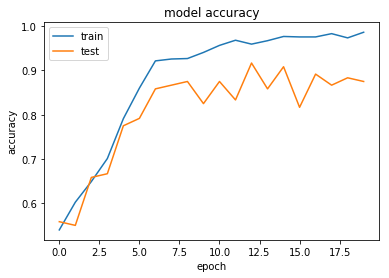

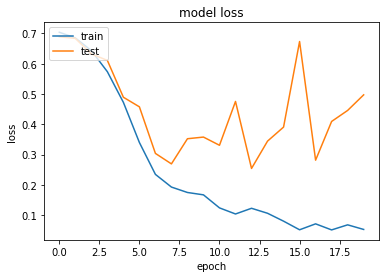

In [0]:
print(hist.history.keys())
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Setp 5: Production

One of the main features and a big reason why this project was chosen is the ability of using the model live easily. In other words, to detect using the laptop's webcam if someone is smiling or not and showing it instantly. 

This was partially done, due to Google Colab restrictions to use the webcam. It was achieved to capture an image, store it in a temp file and finally analising it with the model. 

The model predictions, however, were not as good as expected (90% accuracy as it showed the validation accuracy). The main reason was the nature of the images used to train it. They were the best found, showing a huge variety of subjects in different situations and scenarios, as mentioned before. However, all those photos had the mouth of the subject centered. This is thought to be the reason that made the model not as accurate using the pictures taken with the webcam.

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    return b64decode(data.split(',')[1])
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return filename


In [0]:
from IPython.display import Image
try:
    image = take_photo()
    print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

<IPython.core.display.Javascript object>